In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import gurobipy as gp
from gurobipy import GRB
from itertools import permutations
from itertools import combinations
import random
from random import choice
import time
import copy
import pandas as pd
from scipy.stats import bernoulli
import cvxpy as cp

In [2]:
np.random.seed(1)
random.seed(1)

In [3]:
eps=0.00001

In [4]:
def collection_distribution_mnl(n,collection,v):
    
    collection_distribution = np.zeros((n,len(collection)))

    
    for i in range(len(collection)):
        curr_total_v = 0
        for j in range(len(collection[i])): 
            curr_total_v = curr_total_v + math.exp(v[collection[i][j]])

        for k in range(len(collection[i])):
            collection_distribution[collection[i][k]][i] = math.exp(v[collection[i][k]])/curr_total_v

    return collection_distribution

### MDM MILP

In [5]:
### MDM prediction MILP MIN
def robust_mdm_revenue(data,collection,unseen_assortment,price,true_choice_prob):
    #print('The unseen assortment is',unseen_assortment)
    #print('the seen data is ',data )
    eps = math.pow(10,-6)
    l = len(unseen_assortment)
    n,m = data.shape
    
    ind = [[] for i in range(n)]  ## keeps tracking of the assortments including product i 
    for i in range(len(collection)):
        for j in collection[i]:
            ind[j].append(i) ## assortment i includes product j 
    
    ## MILP for revenue prediction
    x = cp.Variable(shape=l,nonneg = True) ## prob vector for unseen assortment
    delta_plus = cp.Variable(m,boolean=True)  ## indicator variables delta(S)+
    delta_minu = cp.Variable(m,boolean=True)  ## indicator variables delta(S)-
    #z = cp.Variable((l,m), boolean = True)  ## indicator variables z(i,A,S) 
    #y = cp.Variable(shape=l,boolean=True)  ## indicator variables y(i,A)  # indicator of sgn of x(i,A)
    eta = cp.Variable(1,nonneg=True)     ## lambda(A) 
    lam = cp.Variable(shape=m,nonneg=True)  ## lambda_S S stands for assortment
    
    
    ## normalization constraints of unseen assortment and bound on the lambda(A)
    
    constraints = [cp.sum(x)==1]
    constraints += [eta<=1]
        

    ### out-of-sample MDM consistency    
    for k in range(len(unseen_assortment)):
        #constraints += [x[k]-1+y[k]<=0]
        
        #for i in range(len(ind[unseen_assortment[k]])):
        for i in ind[unseen_assortment[k]]:
            #print('the comparison product',unseen_assortment[k])
            #print('the comparison assortment is',ind[unseen_assortment[k]][i])
            #print('the comparison data is ',data[unseen_assortment[k]][ind[unseen_assortment[k]][i]])
            constraints += [eta - lam[i] + delta_plus[i]>=0]
            constraints += [eta - lam[i] - 1 + delta_plus[i] + eps*delta_plus[i]<=0]
            constraints += [lam[i] - eta + delta_minu[i]>=0]
            constraints += [lam[i] - eta  - 1 + delta_minu[i] + eps*delta_minu[i]<=0]
            
            constraints += [x[k]-data[unseen_assortment[k]][i] - delta_plus[i] +1 >=0]
            constraints += [x[k]-data[unseen_assortment[k]][i] + delta_minu[i] -1 <=0]
            
            constraints += [x[k]-data[unseen_assortment[k]][i] + delta_plus[i] +delta_minu[i] >=0]
            constraints += [x[k]-data[unseen_assortment[k]][i] - delta_plus[i] -delta_minu[i]<=0]
              
      
    ## in-sample MDM constraints
    for i in range(n):
        if len(ind[i])>1: ### the comparison happens when there are at least two assortments including product i 
            for j in range(len(ind[i])-1):
                for k in range(j+1,len(ind[i])):
                    if data[i][ind[i][j]] < data[i][ind[i][k]]:
                        constraints += [lam[ind[i][j]] - lam[ind[i][k]] - eps >=0]
                    if data[i][ind[i][k]] < data[i][ind[i][j]]:
                        constraints += [lam[ind[i][k]] - lam[ind[i][j]] - eps >=0]
                    if data[i][ind[i][k]] == data[i][ind[i][j]]:
                        constraints += [lam[ind[i][k]] - lam[ind[i][j]] ==0]
                        
    ## bounds for lambda
    for i in range(m):
        constraints += [lam[i]<=1] 
        
    ### testing the true values
    ''' for i in range(len(unseen_assortment)):
        constraints += [x[i]==true_choice_prob[i]] '''
    
    ## objective  
    obj = cp.Minimize(sum(price[unseen_assortment[i]]*x[i] for i in range(len(unseen_assortment))))
    
    prob = cp.Problem(obj,constraints)
    prob.solve()     
    
    return [prob.value,x.value,lam.value,eta.value]


In [6]:
### MDM prediction MILP MIN
def ucb_mdm_revenue(data,collection,unseen_assortment,price,true_choice_prob):
    #print('The unseen assortment is',unseen_assortment)
    #print('the seen data is ',data )
    eps = math.pow(10,-6)
    l = len(unseen_assortment)
    n,m = data.shape
    
    ind = [[] for i in range(n)]  ## keeps tracking of the assortments including product i 
    for i in range(len(collection)):
        for j in collection[i]:
            ind[j].append(i) ## assortment i includes product j 
    
    ## MILP for revenue prediction
    x = cp.Variable(shape=l,nonneg = True) ## prob vector for unseen assortment
    delta_plus = cp.Variable(m,boolean=True)  ## indicator variables delta(S)+
    delta_minu = cp.Variable(m,boolean=True)  ## indicator variables delta(S)-
    #z = cp.Variable((l,m), boolean = True)  ## indicator variables z(i,A,S) 
    #y = cp.Variable(shape=l,boolean=True)  ## indicator variables y(i,A)  # indicator of sgn of x(i,A)
    eta = cp.Variable(1,nonneg=True)     ## lambda(A) 
    lam = cp.Variable(shape=m,nonneg=True)  ## lambda_S S stands for assortment
    
    
    ## normalization constraints of unseen assortment and bound on the lambda(A)
    
    constraints = [cp.sum(x)==1]
    constraints += [eta<=1]
        

    ### out-of-sample MDM consistency    
    for k in range(len(unseen_assortment)):
        #constraints += [x[k]-1+y[k]<=0]
        
        #for i in range(len(ind[unseen_assortment[k]])):
        for i in ind[unseen_assortment[k]]:
            #print('the comparison product',unseen_assortment[k])
            #print('the comparison assortment is',ind[unseen_assortment[k]][i])
            #print('the comparison data is ',data[unseen_assortment[k]][ind[unseen_assortment[k]][i]])
            constraints += [eta - lam[i] + delta_plus[i]>=0]
            constraints += [eta - lam[i] - 1 + delta_plus[i] + eps*delta_plus[i]<=0]
            constraints += [lam[i] - eta + delta_minu[i]>=0]
            constraints += [lam[i] - eta  - 1 + delta_minu[i] + eps*delta_minu[i]<=0]
            
            constraints += [x[k]-data[unseen_assortment[k]][i] - delta_plus[i] +1 >=0]
            constraints += [x[k]-data[unseen_assortment[k]][i] + delta_minu[i] -1 <=0]
            
            constraints += [x[k]-data[unseen_assortment[k]][i] + delta_plus[i] +delta_minu[i] >=0]
            constraints += [x[k]-data[unseen_assortment[k]][i] - delta_plus[i] -delta_minu[i]<=0]
              
      
    ## in-sample MDM constraints
    for i in range(n):
        if len(ind[i])>1: ### the comparison happens when there are at least two assortments including product i 
            for j in range(len(ind[i])-1):
                for k in range(j+1,len(ind[i])):
                    if data[i][ind[i][j]] < data[i][ind[i][k]]:
                        constraints += [lam[ind[i][j]] - lam[ind[i][k]] - eps >=0]
                    if data[i][ind[i][k]] < data[i][ind[i][j]]:
                        constraints += [lam[ind[i][k]] - lam[ind[i][j]] - eps >=0]
                    if data[i][ind[i][k]] == data[i][ind[i][j]]:
                        constraints += [lam[ind[i][k]] - lam[ind[i][j]] ==0]
                        
    ## bounds for lambda
    for i in range(m):
        constraints += [lam[i]<=1] 
        
    ### testing the true values
    ''' for i in range(len(unseen_assortment)):
        constraints += [x[i]==true_choice_prob[i]] '''
    
    ## objective  
    obj = cp.Maximize(sum(price[unseen_assortment[i]]*x[i] for i in range(len(unseen_assortment))))
    
    prob = cp.Problem(obj,constraints)
    prob.solve()     
    
    return [prob.value,x.value,lam.value,eta.value]


### APU prediction MILP

In [8]:
def robust_apu_prediction(data,collection,unseen_assortment,price,true_choice_prob):

    new_collection = copy.deepcopy(collection)
    new_collection.append(unseen_assortment)
    
    n = data.shape[0]
    m = len(new_collection)
    row = [] #products 
    col = [] # assortments
    
    ## find all product-assortment pairs  
    for i in range(m):
        for j in new_collection[i]:
            row.append(j)
            col.append(i) 
            
    ## MILP for revenue prediction
    x = cp.Variable((n,m),nonneg=True)
    delta = cp.Variable((n*m,n*m),boolean=True)
    lam = cp.Variable(shape=m)
    v = cp.Variable(shape=n)
    
    #add constraints
    #normalization conditions
    constraints = [sum(x[:,len(collection)])==1]
    
    ### testing the true values
    ''' for i in range(len(unseen_assortment)):
        constraints += [x[unseen_assortment[i]][len(collection)]==true_choice_prob[i]] '''
    #constraints = [sum(x[:,j])==1 for j in range(m)]
    for i in range(len(collection)):
        for j in collection[i]:
            constraints += [x[j][i]-data[j][i]==0]
            
    # if product not in the assortment the choice probabilities should be zero
    for i in range(n):
        if i not in new_collection[-1]:
            constraints += [x[i][m-1]==0]
    
    for i in range(len(row)):
        constraints += [lam[col[i]]-v[row[i]]<=1]
        constraints += [lam[col[i]]-v[row[i]]>=0]
        
    # add APU(G-MDM) constraints
    for i in range(len(row)):
        for j in range(len(row)):
            if i !=j:
                constraints += [lam[col[i]]-v[row[i]]-lam[col[j]]+v[row[j]]+ delta[row[i]*m+col[i]][row[j]*m+col[j]]>=0]
                constraints += [lam[col[i]]-v[row[i]]-lam[col[j]]+v[row[j]] -1 + delta[row[i]*m+col[i]][row[j]*m+col[j]] + eps*delta[row[i]*m+col[i]][row[j]*m+col[j]] <=0]
                
                constraints += [x[row[i]][col[i]] - x[row[j]][col[j]] +1 - delta[row[i]*m+col[i]][row[j]*m+col[j]]>=0]
                constraints += [x[row[i]][col[i]] - x[row[j]][col[j]] -1 + delta[row[j]*m+col[j]][row[i]*m+col[i]]<=0]
                
                constraints += [x[row[i]][col[i]] - x[row[j]][col[j]] + delta[row[i]*m+col[i]][row[j]*m+col[j]] + delta[row[j]*m+col[j]][row[i]*m+col[i]] >=0]
                constraints += [x[row[i]][col[i]] - x[row[j]][col[j]] - delta[row[i]*m+col[i]][row[j]*m+col[j]] - delta[row[j]*m+col[j]][row[i]*m+col[i]] <=0]
    
    ## objective  
    obj = cp.Minimize(sum(price[i]*x[i][len(collection)] for i in range(n)))
    
    prob = cp.Problem(obj,constraints)
    prob.solve()     
    
    return [prob.value,x.value]          
            

In [9]:
def ucb_apu_prediction(data,collection,unseen_assortment,price,true_choice_prob):
    
    new_collection = copy.deepcopy(collection)
    new_collection.append(unseen_assortment)
    
    n = data.shape[0]
    m = len(new_collection)
    row = [] #products 
    col = [] # assortments
    
    ## find all product-assortment pairs  
    for i in range(m):
        for j in new_collection[i]:
            row.append(j)
            col.append(i) 
            
    ## MILP for revenue prediction
    x = cp.Variable((n,m),nonneg=True)
    delta = cp.Variable((n*m,n*m),boolean=True)
    lam = cp.Variable(shape=m)
    v = cp.Variable(shape=n)
    
    #add constraints
    #normalization conditions
    constraints = [sum(x[:,len(collection)])==1]
    
    ### testing the true values
    ''' for i in range(len(unseen_assortment)):
        constraints += [x[unseen_assortment[i]][len(collection)]==true_choice_prob[i]] '''
    #constraints = [sum(x[:,j])==1 for j in range(m)]
    for i in range(len(collection)):
        for j in collection[i]:
            constraints += [x[j][i]-data[j][i]==0]
            
    # if product not in the assortment the choice probabilities should be zero
    for i in range(n):
        if i not in new_collection[-1]:
            constraints += [x[i][m-1]==0]
    
    for i in range(len(row)):
        constraints += [lam[col[i]]-v[row[i]]<=1]
        constraints += [lam[col[i]]-v[row[i]]>=0]
        
    # add APU(G-MDM) constraints
    for i in range(len(row)):
        for j in range(len(row)):
            if i !=j:
                constraints += [lam[col[i]]-v[row[i]]-lam[col[j]]+v[row[j]]+ delta[row[i]*m+col[i]][row[j]*m+col[j]]>=0]
                constraints += [lam[col[i]]-v[row[i]]-lam[col[j]]+v[row[j]] -1 + delta[row[i]*m+col[i]][row[j]*m+col[j]] + eps*delta[row[i]*m+col[i]][row[j]*m+col[j]] <=0]
                
                constraints += [x[row[i]][col[i]] - x[row[j]][col[j]] +1 - delta[row[i]*m+col[i]][row[j]*m+col[j]]>=0]
                constraints += [x[row[i]][col[i]] - x[row[j]][col[j]] -1 + delta[row[j]*m+col[j]][row[i]*m+col[i]]<=0]
                
                constraints += [x[row[i]][col[i]] - x[row[j]][col[j]] + delta[row[i]*m+col[i]][row[j]*m+col[j]] + delta[row[j]*m+col[j]][row[i]*m+col[i]] >=0]
                constraints += [x[row[i]][col[i]] - x[row[j]][col[j]] - delta[row[i]*m+col[i]][row[j]*m+col[j]] - delta[row[j]*m+col[j]][row[i]*m+col[i]] <=0]
    
    ## objective  
    obj = cp.Maximize(sum(price[i]*x[i][len(collection)] for i in range(n)))
    
    prob = cp.Problem(obj,constraints)
    prob.solve()     
    
    return [prob.value,x.value]          
            

### instances generation

In [10]:
n = 7
price = np.random.uniform(1,7,n)
instance_size = 100
#collection_size = [20]
#collection_size = [2,3,5,10,15,20]
collection_size = [2,3,5,10,15]
#alpha = 0.5

all_size2_ass = [list(x) for x in list(combinations(range(n),2))]
all_size3_ass = [list(x) for x in list(combinations(range(n),3))]
#all_size4_ass = [list(x) for x in list(combinations(range(n),4))]
#all_possible_assortment = all_size2_ass + all_size3_ass + all_size4_ass
all_possible_assortment = all_size2_ass + all_size3_ass 
#print(len(all_possible_assortment))

#std = 0.01


all_collection = [[] for _ in range(len(collection_size))]

# construct 1000 samples of random assortment size collection of first collection size
for j in range(instance_size):
    collection = []
    while(len(collection)<collection_size[0]):
        S = all_possible_assortment[np.random.randint(len(all_possible_assortment))]
        if S not in collection:
            collection.append(S)
    all_collection[0].append(collection)


for i in range(1,len(collection_size)):
    all_collection[i] = copy.deepcopy(all_collection[i-1])
    for j in range(instance_size):
        while(len(all_collection[i][j])<collection_size[i]):
            S = all_possible_assortment[np.random.randint(len(all_possible_assortment))]
            if S not in all_collection[i][j]:
                all_collection[i][j].append(S)

all_instance = []
all_parameters = []
for i in range(len(collection_size)):
    collection_ins = []  
    parameter_ins =[]
    for j in range(instance_size):
        v = np.random.normal(0,1,size=n) #standard normal
        parameter_ins.append(v)
        curr_coll_mnl = collection_distribution_mnl(n,all_collection[i][j],v)
        collection_ins.append(curr_coll_mnl)
        #collection_ins.append(gaussian_noise(curr_coll_mnl,std,alpha))
    all_parameters.append(parameter_ins)
    all_instance.append(collection_ins)

### Revenue and Choice Probability Prediction

In [11]:
apu_min = []
apu_max = []

mdm_min = []
mdm_max = []

apu_avg_len_interval = []
mdm_avg_len_interval = []

apu_len_interval_se = []
mdm_len_interval_se = []

apu_runtime_list = []
mdm_runtime_list = []

for i in range(len(all_instance)): # instance of the same collection size i 
    print('solving the instance of collection size',collection_size[i])
    true_revenue_list = []

    apu_min_list =[]
    apu_max_list =[]

    mdm_min_list = []
    mdm_max_list = []
    
    apu_runtime = []
    mdm_runtime =[]
    
    apu_curr_ins_len = []
    mdm_curr_ins_len = []
    
    for j in range(len(all_instance[i])): # under the same collection size, there are instances of the instance size 
        curr_instance = all_instance[i][j]  
        curr_collection = all_collection[i][j]
        curr_v = all_parameters[i][j]
        #print('the current parameter list',curr_v)
        ## generate new assortment
        len_S = 2
        if np.random.random()>0.5:
            len_S = 3
        
        available  = np.unique(all_instance[i][j].nonzero()[0])
        available = list(available)
        new_assortment = random.sample(available,len_S) 
        new_assortment.sort()
        
        ## True revenue computation
        
        total_exp_v = 0
        for k in new_assortment:
            total_exp_v = total_exp_v + math.exp(curr_v[k])
            
        true_choice_prob = []
        for k in new_assortment:
            true_choice_prob.append(math.exp(curr_v[k])/total_exp_v)
        
        true_revenue = 0 
        for k in range(len(new_assortment)):
            true_revenue = true_revenue + price[new_assortment[k]]*true_choice_prob[k]
        #print('ground truth',true_revenue)   
        true_revenue_list.append(true_revenue)
        
        # MDM prediction

        mdm_lb = robust_mdm_revenue(curr_instance,curr_collection,new_assortment,price,true_choice_prob)[0]
        #print('testing results LB',mdm_lb)
        mdm_ub = ucb_mdm_revenue(curr_instance,curr_collection,new_assortment,price,true_choice_prob)[0]

        ## APU prediction
        apu_lb = robust_apu_prediction(curr_instance,curr_collection,new_assortment,price,true_choice_prob)[0]
        #print('testing APU LB',apu_lb)
        
        apu_ub = ucb_apu_prediction(curr_instance,curr_collection,new_assortment,price,true_choice_prob)[0]
            
        apu_interval_len = apu_ub - apu_lb
        mdm_interval_len = mdm_ub - mdm_lb
        
        apu_curr_ins_len.append(apu_interval_len)
        mdm_curr_ins_len.append(mdm_interval_len)
            

    apu_avg_len_interval.append(np.mean(apu_curr_ins_len))
    mdm_avg_len_interval.append(np.mean(mdm_curr_ins_len)) 
     
    apu_len_interval_se.append(np.std(apu_curr_ins_len)/np.sqrt(len(apu_curr_ins_len)))
    mdm_len_interval_se.append(np.std(mdm_curr_ins_len)/np.sqrt(len(mdm_curr_ins_len)))  

solving the instance of collection size 2
solving the instance of collection size 3
solving the instance of collection size 5
solving the instance of collection size 10
solving the instance of collection size 15


In [12]:
''' output prediction summary '''
prediction = pd.DataFrame({'collection size':collection_size,'apu interval mean':apu_avg_len_interval,'apu interval se':apu_len_interval_se,'mdm interval mean':mdm_avg_len_interval,'mdm interval se':mdm_len_interval_se})
prediction.to_csv('summary/prediction.csv')

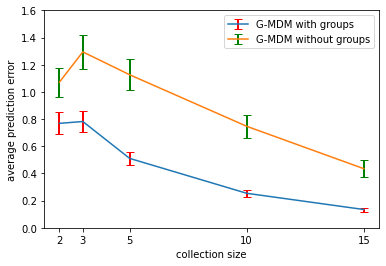

In [17]:
''' visulize the prediction interval comparison '''
plt.errorbar(collection_size,apu_avg_len_interval,yerr=apu_len_interval_se,ecolor='r',elinewidth=2,capsize=4,label = 'G-MDM with groups')
plt.errorbar(collection_size,mdm_avg_len_interval,yerr=mdm_len_interval_se,ecolor='g',elinewidth=2,capsize=4,label = 'G-MDM without groups')
plt.ylim(0, 1.6)
plt.xticks(collection_size,collection_size)
plt.xlabel('collection size',fontsize = 10)
plt.ylabel('average prediction error',fontsize = 10)
plt.legend(loc='upper right')
#plt.title('grouping effect: prediction interval length comparsion')
plt.savefig('summary/revenue_compare_withGroups.pdf')
plt.savefig('summary/revenue_compare_withGroups.png')
plt.show()

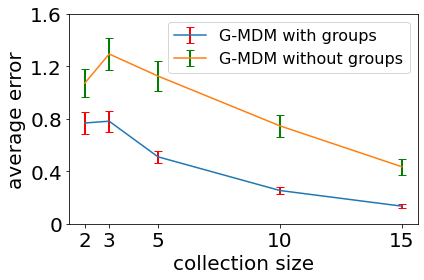

In [28]:
''' visulize the prediction interval comparison '''
plt.errorbar(collection_size,apu_avg_len_interval,yerr=apu_len_interval_se,ecolor='r',elinewidth=2,capsize=4,label = 'G-MDM with groups')
plt.errorbar(collection_size,mdm_avg_len_interval,yerr=mdm_len_interval_se,ecolor='g',elinewidth=2,capsize=4,label = 'G-MDM without groups')
plt.xticks(collection_size,collection_size)
plt.xlabel('collection size',fontsize = 20)
y = [0,0.4,0.8,1.2,1.6]
plt.yticks(y,y)
plt.tick_params(labelsize=20)
plt.ylabel('average error',fontsize = 20)
plt.legend(loc='upper right',fontsize = 16)
#plt.title('grouping effect: prediction interval length comparsion')
plt.tight_layout()
plt.savefig('summary/revenue_withGroups.pdf')
plt.savefig('summary/revenue_withGroups.png')
plt.show()

In [14]:
''' improve precentage '''
improve = []
for i in range(len(apu_avg_len_interval)):
    improve.append((mdm_avg_len_interval[i]-apu_avg_len_interval[i])/mdm_avg_len_interval[i])
print('the prediction improvement with grouping',improve)

the prediction improvement with grouping [0.2830411059693578, 0.3957835482149901, 0.5465145688534814, 0.6600063049523969, 0.6906662356827263]


In [15]:
prediction['improvement'] = improve
prediction.to_csv('summary/summary2.csv')